In [7]:
import os

import gym
from gym import spaces

import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg
import math
from scipy.stats import unitary_group

from stable_baselines3 import PPO
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps

## Obs space [$X$ $s_1$ $Y$ $s_2$ -1 -1 -1 -1], $s_i \in \{0,1\}$

In [8]:
class measurement_env(gym.Env):
    metadata = {'render.modes': ['human']}
    
    q_zero = np.array([[1],[0]])
    H = np.array([[1,1],[1,-1]])/np.sqrt(2)
    qubit_plus = H@q_zero
    sx = np.array([[0,1],[1,0]])
    sz = np.array([[1,0],[0,-1]])
    
    def __init__(self, n_qubits, unitary):
        self.n_qubits = n_qubits
        self.unitary = unitary
        self.action_space = spaces.Box(low = np.array([0]), high=np.array([2*np.pi]) )
        self.observation_space = spaces.Box(low=-1*np.ones(2*self.n_qubits), high=2*np.pi*np.ones(2*self.n_qubits))

        self.state = -1*np.ones(2*self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        st = unitary_group.rvs(2)@q_zero
        #st = q_zero
        self.final_qstate = self.pure2density(self.unitary@st)
        
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        

    def step(self, action):
        current_measurement = self.total_measurements - self.measurements_left
        self.state[2*current_measurement] = action[0]

        self.qstate, outcome = self.measure_angle(self.qstate, action[0],current_measurement)
        
        self.state[2*current_measurement+1] = outcome
        
        reward = 0 #fidelity
        
        self.measurements_left -= 1
        
        if self.measurements_left == 0:
            sx = np.array([[0,1],[1,0]])
            sz = np.array([[1,0],[0,-1]])
            last_qbit = self.partial_trace(self.qstate,[i for i in range(0,self.n_qubits)])
            ssx = int(np.sum(self.state[3::4])%2)
            ssz = int(np.sum(self.state[1::4])%2)
            byprod = np.linalg.matrix_power(sx,ssx)@np.linalg.matrix_power(sz,ssz)
            last_qbit = byprod@last_qbit@(np.conjugate(byprod.T))
            reward = self.fidelity(last_qbit, self.final_qstate)
            done = True
        else:
            done = False
        
        info = {}

        return self.state, reward, done, info
        
        
    def reset(self):
        
        self.state = -1*np.ones(2*self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        st = unitary_group.rvs(2)@q_zero
        #st = q_zero
        self.final_qstate = self.pure2density(self.unitary@st)
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
          
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def controlled_z(self, i, j , n):
        op1, op2 = 1, 2
        for k in range(1,n+1):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2


    def create_1D_gs(self, n):
        psi = 1
        for i in range(1,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi

    def create_1D_gs_input(self, psi, n):
        for i in range(2,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi    

    def fidelity(self, sigma, rho):
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        n = self.n_qubits+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))

        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
        
        return rho, measurement

    def partial_trace(self, rho, indices):
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma

In [9]:
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    return np.convolve(values, weights, 'valid')


def plot_results(log_folder, title='Learning Curve'):
    
    x, y = ts2xy(load_results(log_folder), 'timesteps')
    y = moving_average(y, window=50)
    x = x[len(x) - len(y):]

    fig = plt.figure(title)
    plt.plot(x, y)
    plt.xlabel('Steps')
    plt.ylabel('Average Fidelity')
    plt.title(title + " Smoothed")
    plt.show()


## Test Hadamard

In [11]:
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])
env = measurement_env(4,H)
state = env.reset()
done = False
score = 0
n_state, reward, done, info = env.step([0.0])
score += reward  
n_state, reward, done, info = env.step([3*np.pi/2])
score += reward  
n_state, reward, done, info = env.step([3*np.pi/2])
score += reward  
n_state, reward, done, info = env.step([3*np.pi/2])
score += reward  
score

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


0.6163778949672467

In [834]:
env = measurement_env(4,H)
log_dirN1 = "./logsN1/"
os.makedirs(log_dirN1, exist_ok=True)
env = Monitor(env, log_dirN1)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logsN1/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [835]:
model = PPO("MlpPolicy", env, verbose=0);
model.learn(total_timesteps=int(5e4), callback=event_callback);

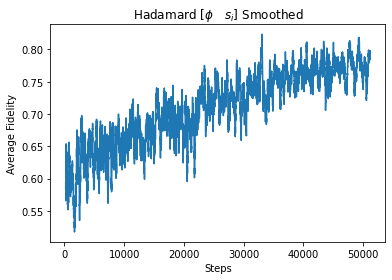

In [836]:
plot_results(log_dirN1, title=r"Hadamard $[\phi \quad s_i]$")

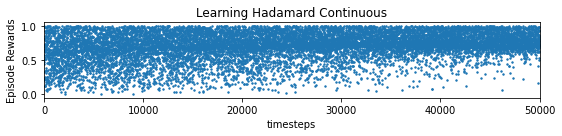

In [837]:
results_plotter.plot_results(['./logsN1/'], 5e4, results_plotter.X_TIMESTEPS, "Learning Hadamard Continuous");

In [769]:
env = measurement_env(4,H)
obs = env.reset()
for i in range(16):
    action, states = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print("STATE",obs,"\nACTION", action)
    if done:
        print("donee, score: ", reward)
        obs = env.reset()
        print(reward)

env.close()

STATE [ 2.92231011  0.         -1.         -1.         -1.         -1.
 -1.         -1.        ] 
ACTION [2.92231]
STATE [ 2.92231011  0.          0.          0.         -1.         -1.
 -1.         -1.        ] 
ACTION [0.]
STATE [ 2.92231011  0.          0.          0.          0.          0.
 -1.         -1.        ] 
ACTION [0.]
STATE [2.92231011 0.         0.         0.         0.         0.
 0.         1.        ] 
ACTION [0.]
donee, score:  0.7393156669587383
0.7393156669587383
STATE [ 2.92231011  0.         -1.         -1.         -1.         -1.
 -1.         -1.        ] 
ACTION [2.92231]
STATE [ 2.92231011  0.          0.          1.         -1.         -1.
 -1.         -1.        ] 
ACTION [0.]
STATE [ 2.92231011  0.          0.          1.          0.          1.
 -1.         -1.        ] 
ACTION [0.]
STATE [2.92231011 0.         0.         1.         0.         1.
 0.         0.        ] 
ACTION [0.]
donee, score:  0.7329947835108067
0.7329947835108067
STATE [ 2.92231011  

C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


# Obs space2 : [$X$ $Y$ -1 -1]

In [21]:
def brownian_circuit(dim, n, dt):
    u = np.eye(dim)
    for j in range(n):
        re = np.random.normal(size=(dim,dim))
        im = 1j*np.random.normal(size=(dim,dim))
        c = re + im
        h = (c+np.conj(c.T))/4
        u = u@scp.linalg.expm(1j*h*dt)
    return u

def randomUnitary_closetoid(dim, t, n):
    return brownian_circuit(dim,n, np.sqrt(1/(n*dim))*2*np.pi*t)

randomUnitary_closetoid(2,0.05,20)

array([[ 0.99147902-1.05447688e-01j, -0.07648006+9.68817650e-04j],
       [ 0.07648618+5.94770143e-05j,  0.99266261+9.36525317e-02j]])

In [22]:
class measurement_env2(gym.Env):
    metadata = {'render.modes': ['human']}
    
    q_zero = np.array([[1],[0]])
    H = np.array([[1,1],[1,-1]])/np.sqrt(2)
    qubit_plus = H@q_zero
    sx = np.array([[0,1],[1,0]])
    sz = np.array([[1,0],[0,-1]])
    
    def __init__(self, n_qubits, unitary, random_reset=0, power_reward = 1, noise=False):
        self.n_qubits = n_qubits
        self.unitary = unitary
        self.noise = noise
        self.random_reset = random_reset
        self.power_reward = power_reward
        self.action_space = spaces.Box(low = np.array([-1*(np.pi+0.1)]), high=np.array([1*(np.pi+0.1)]) )
        self.observation_space = spaces.Box(low=-4*np.ones(self.n_qubits), high=1*(np.pi+0.1)*np.ones(self.n_qubits))
        
        
        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        if self.random_reset==0:
            st = unitary_group.rvs(2)@q_zero
        elif self.random_reset==1:
            st = q_zero
        elif self.random_reset==2:
            aa = np.random.choice([0,1])
            st = np.array([[aa],[1-aa]])
        elif self.random_reset==3:
            aa = np.random.choice([0,1])
            st =H@np.array([[aa],[1-aa]])
        elif self.random_reset==4:
            aa = np.random.choice([0,1])
            bb = np.random.choice([0,1])
            st =(np.linalg.matrix_power(H,bb))@np.array([[aa],[1-aa]])
        
        if not self.noise:
            self.final_qstate = self.pure2density(self.unitary@st)
        elif self.noise:
            noisyU = randomUnitary_closetoid(2,0.05,20)
            self.final_qstate = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0

    def step(self, action):
        current_measurement = self.total_measurements - self.measurements_left
        self.state[current_measurement] = action[0]
        corrected_action = action[0]
        if current_measurement%2==0:
            corrected_action =(corrected_action*((-1)**(self.s_even%2)))
        elif current_measurement%2==1:
            corrected_action =(corrected_action*((-1)**(self.s_odd%2)))
        
        self.qstate, outcome = self.measure_angle(self.qstate, corrected_action,current_measurement)
        
        if current_measurement%2==0:
            self.s_odd += int(outcome)
        elif current_measurement%2==1:
            self.s_even += int(outcome)
        
        reward = 0 #fidelity
        
        self.measurements_left -= 1
        if self.measurements_left == 0:
            sx = np.array([[0,1],[1,0]])
            sz = np.array([[1,0],[0,-1]])
            last_qbit = self.partial_trace(self.qstate,[i for i in range(0,self.n_qubits)])
            ssx =int(self.s_even%2)
            ssz =int(self.s_odd%2)
            byprod = np.linalg.matrix_power(sx,ssx)@np.linalg.matrix_power(sz,ssz)
            last_qbit = byprod@last_qbit@(np.conjugate(byprod.T))
            reward = self.fidelity(last_qbit, self.final_qstate)
            reward = reward**self.power_reward
            done = True
        else:
            done = False
        
        info = {}

        return self.state, reward, done, info
        
        
    def reset(self):
        
        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits

        if self.random_reset==0:
            st = unitary_group.rvs(2)@q_zero
        elif self.random_reset==1:
            st = q_zero
        elif self.random_reset==2:
            aa = np.random.choice([0,1])
            st = np.array([[aa],[1-aa]])
        elif self.random_reset==3:
            aa = np.random.choice([0,1])
            st =H@np.array([[aa],[1-aa]])
        elif self.random_reset==4:
            aa = np.random.choice([0,1])
            bb = np.random.choice([0,1])
            st =(np.linalg.matrix_power(H,bb))@np.array([[aa],[1-aa]])

            
        if not self.noise:
            self.final_qstate = self.pure2density(self.unitary@st)
        elif self.noise:
            noisyU = randomUnitary_closetoid(2,0.05,20)
            self.final_qstate = self.pure2density(noisyU@self.unitary@(np.conj(noisyU.T))@st)
        
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0
          
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def controlled_z(self, i, j , n):
        op1, op2 = 1, 2
        for k in range(1,n+1):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2


    def create_1D_gs(self, n):
        psi = 1
        for i in range(1,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi

    def create_1D_gs_input(self, psi, n):
        for i in range(2,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi    

    def fidelity(self, sigma, rho):
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        n = self.n_qubits+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))

        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
        
        return rho, measurement

    def partial_trace(self, rho, indices):
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma

In [ ]:
def hessian_of_point(angles, rhoIn, rhoOut):
    
    pass

## Test Hadamard

In [23]:
q_zero = np.array([[1],[0]])
qubit_plus = H@q_zero
sx = np.array([[0,1],[1,0]])
sz = np.array([[1,0],[0,-1]])
H = np.array([[1,1],[1,-1]])/np.sqrt(2)
env = measurement_env2(4,H, noise=True)
state = env.reset()
done = False
score = 0
n_state, reward, done, info = env.step([-np.pi/4])
score += reward  
n_state, reward, done, info = env.step([-np.pi/2])
score += reward  
n_state, reward, done, info = env.step([-np.pi/2])
score += reward  
n_state, reward, done, info = env.step([-np.pi/4])
score += reward  
score

1.0000000107784996

In [24]:
unitary_group.rvs(2)@q_zero

array([[ 0.12053193-0.64526549j],
       [-0.66082733+0.36388425j]])

## Learns Hadamard Gate

In [25]:
env = measurement_env2(4,H, random_reset=0, noise=True)

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [26]:
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=int(5e4), callback=event_callback)

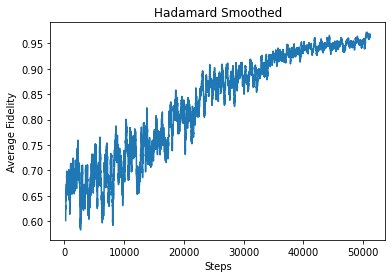

In [27]:
plot_results(log_dir, title="Hadamard")

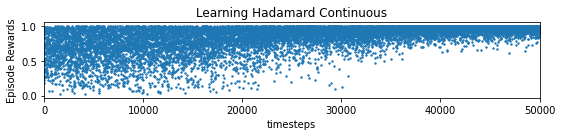

In [28]:
results_plotter.plot_results([log_dir], 5e4, results_plotter.X_TIMESTEPS, "Learning Hadamard Continuous")

In [42]:
env = measurement_env2(4,H, random_reset=0, noise=True)
for i in range(1):
    obs = env.reset()
    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        print(action)
        if done:
            print("donee, score: ", reward)
env.close()

[-0.733918]
[-1.5881238]
[-1.5410858]
[-0.8119214]
donee, score:  0.9722220778750614


In [36]:
old_noRL = []
env = measurement_env2(4,H, noise=True)

for i in range(100):
    state = env.reset()
    done = False
    score = 0
    n_state, reward, done, info = env.step([0.0])
    score += reward  
    n_state, reward, done, info = env.step([-np.pi/2])
    score += reward  
    n_state, reward, done, info = env.step([-np.pi/2])
    score += reward  
    n_state, reward, done, info = env.step([-np.pi/2])
    score += reward  
    old_noRL+=[score]

new_RL = []
for i in range(100):
    obs = env.reset()
    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        if done:
            new_RL += [reward]            


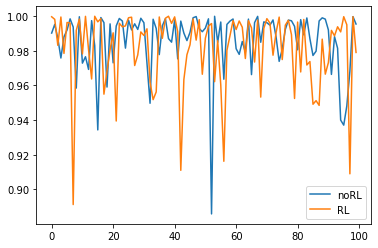

In [37]:
plt.plot(old_noRL, label = "noRL")
plt.plot(new_RL, label= "RL")
plt.legend()

In [40]:
print("no RL avg: ",np.mean(np.array(old_noRL)) )
print("RL avg: ", np.mean(np.array(new_RL)))

no RL avg:  0.9856927642966595
RL avg:  0.9815078628626653


## Test S^\dagger Gate

In [43]:
S = np.array([[1,0],[0,-1j]])
envS = measurement_env2(4,S, random_reset=0, noise=True)
state = envS.reset()
done = False
score = 0
n_state, reward, done, info = envS.step([0.0])
score += reward  
n_state, reward, done, info = envS.step([0.0])
score += reward  
n_state, reward, done, info = envS.step([np.pi/2])
score += reward  
n_state, reward, done, info = envS.step([0.0])
score += reward  
score

0.9814516721468824

## Learns S^\dagger Gate

In [44]:
S = np.array([[1,0],[0,-1j]])
envS = measurement_env2(4,S, random_reset=0, noise=True)

In [45]:
log_dir2 = "./logs2/"
os.makedirs(log_dir2, exist_ok=True)
envS = Monitor(envS, log_dir2)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs2/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [46]:
modelS = PPO("MlpPolicy", envS, verbose=0)
modelS.learn(total_timesteps=int(5e4), callback=event_callback)

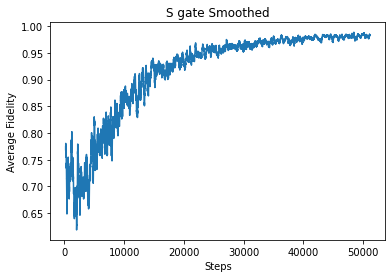

In [47]:
plot_results(log_dir2, title="S gate")

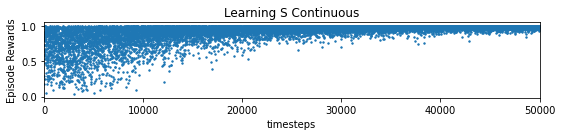

In [48]:
results_plotter.plot_results([log_dir2], 5e4, results_plotter.X_TIMESTEPS, "Learning S Continuous")

In [49]:
envS = measurement_env2(4,S, random_reset=0)
obs = envS.reset()
done = False
while not done:
    action, states = modelS.predict(obs, deterministic=True)
    obs, reward, done, info = envS.step(action)
    print(action)
    if done:
        print("donee, score: ", reward)
env.close()

[1.285475]
[0.03962088]
[0.2698253]
[-0.04607297]
donee, score:  0.9999530249544564


C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [50]:
old_noRL = []
envS =  measurement_env2(4,S, random_reset=0, noise=True)

for i in range(100):
    state = envS.reset()
    done = False
    score = 0
    n_state, reward, done, info = envS.step([0.0])
    score += reward  
    n_state, reward, done, info = envS.step([0.0])
    score += reward  
    n_state, reward, done, info = envS.step([np.pi/2])
    score += reward  
    n_state, reward, done, info = envS.step([0.0])
    score += reward  
    old_noRL+=[score]

new_RL = []
for i in range(100):
    obs = envS.reset()
    done = False
    while not done:
        action, states = modelS.predict(obs, deterministic=True)
        obs, reward, done, info = envS.step(action)
        if done:
            new_RL += [reward]            


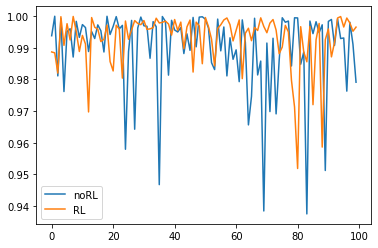

In [51]:
plt.plot(old_noRL, label = "noRL")
plt.plot(new_RL, label= "RL")
plt.legend()

In [52]:
print("no RL avg: ",np.mean(np.array(old_noRL)) )
print("RL avg: ", np.mean(np.array(new_RL)))

no RL avg:  0.9897646636813578
RL avg:  0.9928889252935877


## Learns T^\dagger Gate

In [911]:
Pi8 = np.array([[1,0],[0,np.exp(-1j*np.pi/4)]])
envPi8 = measurement_env2(4,Pi8, random_reset=0)

In [912]:
log_dir3 = "./logs3/"
os.makedirs(log_dir3, exist_ok=True)
envPi8 = Monitor(envPi8, log_dir3)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs3/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [913]:
modelPi8 = PPO("MlpPolicy", envPi8, verbose=0)
modelPi8.learn(total_timesteps=int(5e4), callback=event_callback)

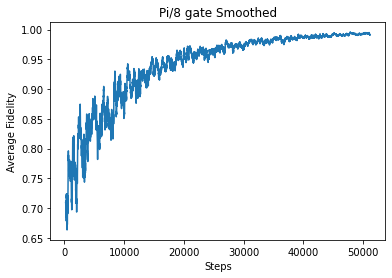

In [914]:
plot_results(log_dir3, title="Pi/8 gate")

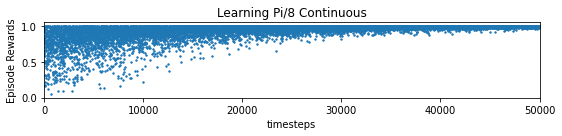

In [915]:
results_plotter.plot_results([log_dir3], 5e4, results_plotter.X_TIMESTEPS, "Learning Pi/8 Continuous")

In [916]:
envPi8 = measurement_env2(4,Pi8, random_reset=0)
obs = envPi8.reset()
done = False
while not done:
    action, states = modelPi8.predict(obs, deterministic=True)
    obs, reward, done, info = envPi8.step(action)
    print(action)
    if done:
        print("donee, score: ", reward)
env.close()

[0.75185573]
[-0.02777523]
[0.0420092]
[-0.00023067]
donee, score:  0.9998930102025826


C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


## Learning normal S (not dagger)...

In [917]:
S = np.array([[1,0],[0,1j]])
envS = measurement_env2(4,S, random_reset=0, power_reward=1)

In [918]:
log_dir4 = "./logs4/"
os.makedirs(log_dir4, exist_ok=True)
envS = Monitor(envS, log_dir4)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs4/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [919]:
modelS = PPO("MlpPolicy", envS, verbose=0,  use_sde=False)
modelS.learn(total_timesteps=int(5e4), callback=event_callback)

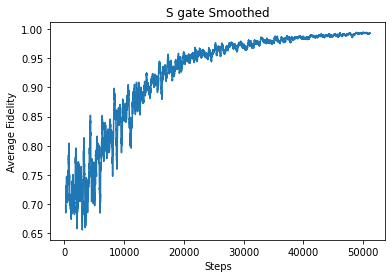

In [920]:
plot_results(log_dir4, title="S gate")

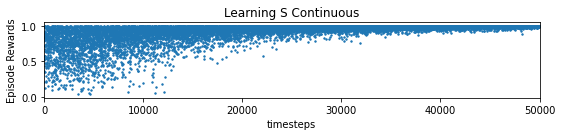

In [921]:
results_plotter.plot_results([log_dir4], 5e4, results_plotter.X_TIMESTEPS, "Learning S Continuous")

use of gde

In [922]:
envS = measurement_env2(4,S, random_reset=0)
obs = envS.reset()
done = False
while not done:
    action, states = modelS.predict(obs, deterministic=True)
    obs, reward, done, info = envS.step(action)
    print(action)
    if done:
        print("donee, score: ", reward)
env.close()

[-1.3965856]
[-0.01326238]
[-0.14802898]
[0.00820545]
donee, score:  0.9999360963689808


C:\Users\luism\anaconda3\envs\gym\lib\site-packages\gym\spaces\box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


In [928]:
S = np.array([[1,0],[0,1j]])
envS = measurement_env2(4,S, random_reset=0, power_reward=1)
state = envS.reset()
done = False
score = 0
n_state, reward, done, info = envS.step([-1.3965856])
score += reward  
n_state, reward, done, info = envS.step([-0.01326238])
score += reward  
n_state, reward, done, info = envS.step([-0.14802898])
score += reward  
n_state, reward, done, info = envS.step([0.00820545])
score += reward  
score

0.9999489215410554

## Learns Random Unitary Gate

In [929]:
U = unitary_group.rvs(2)
envU = measurement_env2(4,U)

log_dirU = "./logsU/"
os.makedirs(log_dirU, exist_ok=True)
envU = Monitor(envU, log_dirU)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logsU/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [930]:
modelU = PPO("MlpPolicy", envU, verbose=0)
modelU.learn(total_timesteps=int(5e4), callback=event_callback)

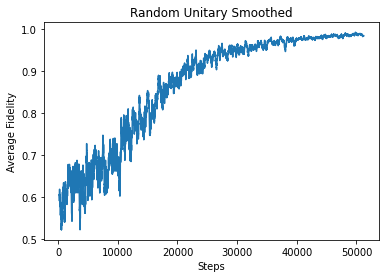

In [945]:
plot_results(log_dirU, title="Random Unitary")

In [944]:
envU = measurement_env2(4,U, random_reset=0)
obs = envU.reset()
done = False
while not done:
    action, states = modelU.predict(obs, deterministic=True)
    obs, reward, done, info = envU.step(action)
    print(action)
    if done:
        print("donee, score: ", reward)
env.close()

[-1.6542972]
[-0.26571956]
[-0.35842323]
[-2.0035493]
donee, score:  0.9993792114240923


# Force first measurement to be 0

In [1236]:
class measurement_env3(gym.Env):
    metadata = {'render.modes': ['human']}
    
    q_zero = np.array([[1],[0]])
    H = np.array([[1,1],[1,-1]])/np.sqrt(2)
    qubit_plus = H@q_zero
    sx = np.array([[0,1],[1,0]])
    sz = np.array([[1,0],[0,-1]])
    
    def __init__(self, n_qubits, unitary, random_reset=0, power_reward = 1):
        self.n_qubits = n_qubits
        self.unitary = unitary
        self.random_reset = random_reset
        self.power_reward = power_reward
        self.action_space = spaces.Box(low = np.array([-1*(np.pi+0.1)]), high=np.array([1*(np.pi+0.1)]) )
        self.observation_space = spaces.Box(low=-4*np.ones(self.n_qubits), high=1*(np.pi+0.1)*np.ones(self.n_qubits))

        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits
        
        if self.random_reset==0:
            st = unitary_group.rvs(2)@q_zero
        elif self.random_reset==1:
            st = q_zero
        elif self.random_reset==2:
            aa = np.random.choice([0,1])
            st = np.array([[aa],[1-aa]])
        elif self.random_reset==3:
            aa = np.random.choice([0,1])
            st =H@np.array([[aa],[1-aa]])
        elif self.random_reset==4:
            aa = np.random.choice([0,1])
            bb = np.random.choice([0,1])
            st =(np.linalg.matrix_power(H,bb))@np.array([[aa],[1-aa]])
            
        self.final_qstate = self.pure2density(self.unitary@st)
        
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0

    def step(self, action):
        current_measurement = self.total_measurements - self.measurements_left
        if current_measurement==0:
            action = [0.0]
        self.state[current_measurement] = action[0]
        corrected_action = action[0]
        if current_measurement%2==0:
            corrected_action =(corrected_action*((-1)**(self.s_even%2)))
        elif current_measurement%2==1:
            corrected_action =(corrected_action*((-1)**(self.s_odd%2)))
    
        
        self.qstate, outcome = self.measure_angle(self.qstate, corrected_action,current_measurement)
        
        if current_measurement%2==0:
            self.s_odd += int(outcome)
        elif current_measurement%2==1:
            self.s_even += int(outcome)
        
        reward = 0 #fidelity
        
        self.measurements_left -= 1
        if self.measurements_left == 0:
            sx = np.array([[0,1],[1,0]])
            sz = np.array([[1,0],[0,-1]])
            last_qbit = self.partial_trace(self.qstate,[i for i in range(0,self.n_qubits)])
            ssx =int(self.s_even%2)
            ssz =int(self.s_odd%2)
            byprod = np.linalg.matrix_power(sx,ssx)@np.linalg.matrix_power(sz,ssz)
            last_qbit = byprod@last_qbit@(np.conjugate(byprod.T))
            reward = self.fidelity(last_qbit, self.final_qstate)
            reward = reward**self.power_reward
            done = True
        else:
            done = False
        
        info = {}

        return self.state, reward, done, info
        
        
    def reset(self):
        
        self.state = -4*np.ones(self.n_qubits)
        self.total_measurements = self.n_qubits
        self.measurements_left = self.n_qubits

        if self.random_reset==0:
            st = unitary_group.rvs(2)@q_zero
        elif self.random_reset==1:
            st = q_zero
        elif self.random_reset==2:
            aa = np.random.choice([0,1])
            st = np.array([[aa],[1-aa]])
        elif self.random_reset==3:
            aa = np.random.choice([0,1])
            st =H@np.array([[aa],[1-aa]])
        elif self.random_reset==4:
            aa = np.random.choice([0,1])
            bb = np.random.choice([0,1])
            st =(np.linalg.matrix_power(H,bb))@np.array([[aa],[1-aa]])

            
        self.final_qstate = self.pure2density(self.unitary@st)
        self.qstate = self.pure2density(self.create_1D_gs_input(st,self.n_qubits+1))
        
        self.s_even = 0
        self.s_odd = 0
          
        return self.state
        
    def render(self, mode='human', close=False):
        pass

    def controlled_z(self, i, j , n):
        op1, op2 = 1, 2
        for k in range(1,n+1):
            op1 = np.kron(op1, np.eye(2))
            if k in [i,j]:
                op2 = np.kron(op2, np.kron(np.conjugate(np.array([[0],[1]]).T), np.array([[0],[1]])))
            else:
                op2 = np.kron(op2, np.eye(2))
        return op1-op2


    def create_1D_gs(self, n):
        psi = 1
        for i in range(1,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi

    def create_1D_gs_input(self, psi, n):
        for i in range(2,n+1):
            psi = np.kron(psi,qubit_plus)
        for i in range(1,n):
            psi = self.controlled_z(i,i+1,n)@psi
        return psi    

    def fidelity(self, sigma, rho):
        srho = linalg.sqrtm(rho)
        prod = srho@sigma@srho
        sprod = linalg.sqrtm(prod)
        return np.abs(np.trace(sprod))

    def pure2density(self, psi):
        return np.kron(psi, np.conjugate(psi.T))

    def measure_angle(self, rho, angle, i):
        n = self.n_qubits+1
        pi0 = 1
        pi1 = 1
        pi0op = np.array([[1, np.exp(-angle*1j)],[np.exp(angle*1j), 1]])/2
        pi1op = np.array([[1,-np.exp(-angle*1j)],[-np.exp(angle*1j), 1]])/2
        for k in range(0,n):
            if k == i:
                pi0 = np.kron(pi0, pi0op)
                pi1 = np.kron(pi1, pi1op)
            else:
                pi0 = np.kron(pi0, np.eye(2))
                pi1 = np.kron(pi1, np.eye(2))
        prob0, prob1 = np.real(np.trace(rho@pi0)), np.real(np.trace(rho@pi1))
        measurement = np.random.choice([0,1], p=[prob0,prob1]/(prob0+prob1))

        if measurement==0:
            rho = pi0@rho@pi0/prob0
        elif measurement==1:
            rho = pi1@rho@pi1/prob1
        
        return rho, measurement

    def partial_trace(self, rho, indices):
        x,y = rho.shape
        n = int(math.log(x,2))
        r = len(indices)
        sigma = np.zeros((int(x/(2**r)), int(y/(2**r))))
        for m in range(0, 2**r):
            qubits = format(m,'0'+f'{r}'+'b')
            ptrace = 1
            for k in range(0,n):
                if k in indices:
                    idx = indices.index(k)
                    if qubits[idx]=='0':
                        ptrace = np.kron(ptrace, np.array([[1],[0]]))
                    elif qubits[idx]=='1':
                        ptrace = np.kron(ptrace, np.array([[0],[1]]))
                else:
                    ptrace = np.kron(ptrace, np.eye(2))
            sigma = sigma + np.conjugate(ptrace.T)@rho@(ptrace)
        return sigma

In [1237]:
env = measurement_env3(4,H, random_reset=0)

log_dir = "./logs/"
os.makedirs(log_dir, exist_ok=True)
env = Monitor(env, log_dir)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logs/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

In [1238]:
model = PPO("MlpPolicy", env, verbose=0)
model.learn(total_timesteps=int(5e4), callback=event_callback)

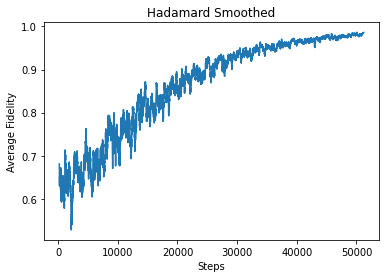

In [1239]:
plot_results(log_dir, title="Hadamard")

In [1288]:
env = measurement_env3(4,H, random_reset=0)
for i in range(1):
    obs = env.reset()
    done = False
    while not done:
        action, states = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        print(action)
        if done:
            print("donee, score: ", reward)
env.close()

[0.2312367]
[-1.5931084]
[-1.5589964]
[-1.5627156]
donee, score:  0.999952933170275


### RANDOM UNITARY (constrained to three measurement) !!

In [17]:
import scipy as scp

In [18]:
def u3(theta, phi, lamb):
    return np.array([[np.cos(theta/2), -np.exp(1j*lamb)*np.sin(theta/2)],[np.exp(1j*phi)*np.sin(theta/2), np.exp(1j*(theta+lamb))*np.cos(theta/2) ]])

def rx(theta):
    return u3(theta, -np.pi/2, np.pi/2)

def ry(theta):
    return u3(theta, 0.0,0.0)

def cost_fun(U,V):
    return np.sum(np.sum(np.abs(U-V)))

def ux(theta):
    return scp.linalg.expm(-1j*theta*sx/2)

def uz(theta):
    return scp.linalg.expm(-1j*theta*sz/2)

def eu_dec(theta, phi, lamb,phase):
    return (np.exp(1j*phase))*ux(theta)@uz(phi)@ux(lamb)

In [19]:
U = unitary_group.rvs(2)
envU = measurement_env3(4,U)

log_dirU = "./logsU/"
os.makedirs(log_dirU, exist_ok=True)
envU = Monitor(envU, log_dirU)

checkpoint_on_event = CheckpointCallback(save_freq=1, save_path='./logsU/')
event_callback = EveryNTimesteps(n_steps=1000, callback=checkpoint_on_event)

NameError: name 'measurement_env3' is not defined

In [20]:
modelU = PPO("MlpPolicy", envU, verbose=0)
modelU.learn(total_timesteps=int(5e4), callback=event_callback)

NameError: name 'envU' is not defined

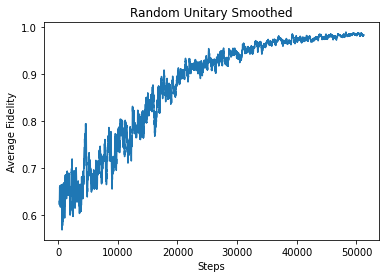

In [1325]:
plot_results(log_dirU, title="Random Unitary")

In [1328]:
envU = measurement_env3(4,U, random_reset=0)
obs = envU.reset()
done = False
j=0
while not done:
    action, states = modelU.predict(obs, deterministic=True)
    obs, reward, done, info = envU.step(action)
    if j==0:
        print([0.0])
        j+=1
    else:
        print(action)
    
    if done:
        print("donee, score: ", reward)
env.close()

[0.0]
[1.2832612]
[-2.087121]
[-1.0582138]
donee, score:  0.9997783328121327


In [1315]:
a=np.random.rand(4)
result = scp.optimize.minimize(lambda b : cost_fun(H, eu_dec(b[0], b[1],b[2],b[3])), a,
                      bounds= ((-np.pi-0.1,np.pi+0.1),(-np.pi-0.1,np.pi+0.1),(-np.pi-0.1,np.pi+0.1), (-np.pi-0.1,np.pi+0.1)), tol=1e-7 )
l,k,m,p = result.x
print(result.fun)

2.1154567996850224e-07


In [1316]:
print("angles", result.x[0:3], "\nphase: ", result.x[-1])

angles [1.57079644 1.57079626 1.57079629] 
phase:  1.5707963811886572


In [1312]:
envU = measurement_env3(4,U, random_reset=0)
obs = envU.reset()
done = False
j=0
actions = [0, 2.33398738, -2.43689243, 0.09903471]
#actions = [0, -0.11147679, 2.5313883, -2.3954027]
while not done:
    action, states = modelU.predict(obs, deterministic=True)
    print(actions[j])
    obs, reward, done, info = envU.step([actions[j]])
    j+=1
    if done:
        print("donee, score: ", reward)
env.close()

0
-0.11147679
2.5313883
-2.3954027
donee, score:  0.9985838444479335


In [976]:
theta, phi, lamb = np.random.rand(3)
u3(theta,phi,lamb)@np.conj(u3(theta,phi,lamb).T)

array([[ 1.        -1.37514377e-18j, -0.07002726-6.63815689e-02j],
       [-0.07002726+6.63815689e-02j,  1.        +8.71448141e-18j]])

In [1319]:
U = unitary_group.rvs(2)
a=np.random.rand(4)
result = scp.optimize.minimize(lambda b : cost_fun(U, eu_dec(b[0], b[1],b[2],b[3])), a,
                      bounds= ((-np.pi,np.pi),(-np.pi,np.pi),(-np.pi,np.pi), (-np.pi,np.pi)), tol=1e-7 )
l,k,m,p = result.x
print(result.fun)

2.341871077450883e-07


In [1320]:
result.x0

array([ 1.64192057, -0.37911733, -1.18425901,  1.13505569])

In [1318]:
a=np.random.rand(4)
result = scp.optimize.minimize(lambda b : cost_fun(U, eu_dec(b[0], b[1],b[2],b[3])), a,
                      bounds= ((-np.pi,np.pi),(-np.pi,np.pi),(-np.pi,np.pi), (-np.pi,np.pi)), tol=1e-4 )
l,k,m,p = result.x
print(result.fun)

0.0001361419389497161


In [1198]:
result

      fun: 2.6837039352448775
 hess_inv: <4x4 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.01607772, -0.76692209, -0.01607745,  0.79220941])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 145
      nit: 12
     njev: 29
   status: 0
  success: True
        x: array([ 0.93406409,  3.14159265, -0.1796378 , -0.72644049])

In [1192]:
cost_fun(U, eu_dec(l,k,m,p))

0.0004559775149184078